In [77]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import ConfusionMatrixDisplay

In [59]:
#Load the MNIST dataset, and split it into a training set, a validation set, and a test set: 50,000instances for training, 10,000 for validation, and 10,000 for testing

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist["data"], mnist["target"]
X = X.astype(np.float32)
y = y.astype(np.int64)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=10000, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full,
                                                    y_train_full,
                                                    test_size=10000,
                                                    random_state=42)        

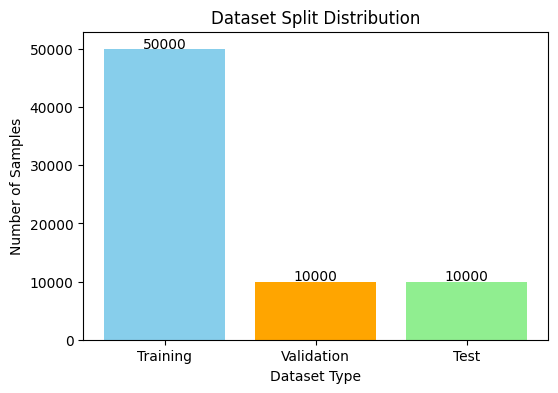

In [60]:
#Show a bar chart representing the number of samples in each dataset split (training, validation, test).

datasets = ['Training', 'Validation', 'Test']
counts = [len(X_train), len(X_valid), len(X_test)]

plt.figure(figsize=(6, 4))
plt.bar(datasets, counts, color=['skyblue', 'orange', 'lightgreen'])

plt.title('Dataset Split Distribution')
plt.xlabel('Dataset Type')
plt.ylabel('Number of Samples')

for i, count in enumerate(counts):
    plt.text(i, count + 200, str(count), ha='center', fontsize=10)

plt.ylim(0, max(counts) + 3000)
plt.show()

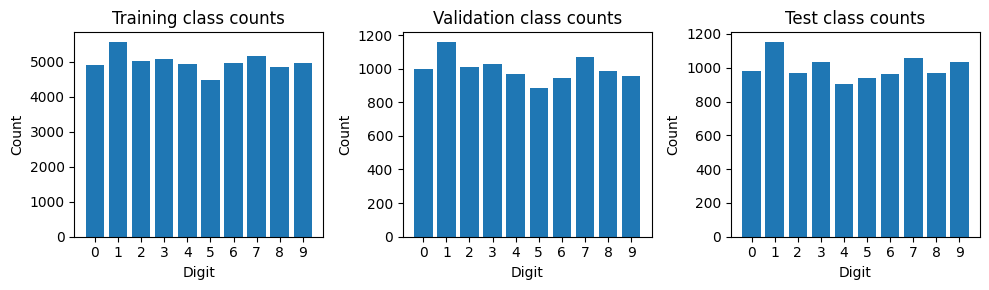

In [61]:
# Show a bar chart representing the number of instances for each digit (0 to 9) in each dataset split.

def plot_class_counts(y_splits, names):
    plt.figure(figsize=(10, 3))
    for i, (y_split, name) in enumerate(zip(y_splits, names), start=1):
        plt.subplot(1, 3, i)
        counts = np.bincount(y_split, minlength=10)
        plt.bar(range(10), counts)
        plt.title(f"{name} class counts")
        plt.xlabel("Digit")
        plt.ylabel("Count")
        plt.xticks(range(10))
    plt.tight_layout()
    plt.show()

plot_class_counts(
    y_splits=[y_train, y_valid, y_test],
    names=["Training", "Validation", "Test"]
)

In [62]:
# RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

rf_val_pred = rf.predict(X_valid)
rf_val_acc = accuracy_score(y_valid, rf_val_pred)
print(f"Validation accuracy(RandomForestClassifier): {rf_val_acc * 100:.2f}%")

Validation accuracy(RandomForestClassifier): 96.92%


In [63]:
rf_y_pred = rf.predict(X_test)
rf_y_pred

array([8, 4, 8, ..., 3, 8, 3], shape=(10000,))

In [64]:
# Calculate the accuracy of the predictions

X_trval = np.vstack([X_train, X_valid])
y_trval = np.hstack([y_train, y_valid])

rf_final = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_final.fit(X_trval, y_trval)

rf_test_pred = rf_final.predict(X_test)
rf_test_acc = accuracy_score(y_test, rf_test_pred)

# Display the test accuracy
print(f"Test accuracy(RandomForestClassifier): {rf_test_acc * 100:.2f}%")

Test accuracy(RandomForestClassifier): 96.65%


In [65]:
# Extra-Trees classifier
et = ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1)
et.fit(X_train, y_train)

et_val_pred = et.predict(X_valid)
et_val_acc = accuracy_score(y_valid, et_val_pred)
print(f"Validation accuracy (Extra-Trees): {et_val_acc * 100:.2f}%")

Validation accuracy (Extra-Trees): 97.15%


In [66]:
et_y_pred = et.predict(X_test)
et_y_pred

array([8, 4, 8, ..., 3, 8, 3], shape=(10000,))

In [67]:
et_final = ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1)
et_final.fit(X_trval, y_trval)
et_test_pred = et_final.predict(X_test)
et_test_acc = accuracy_score(y_test, et_test_pred)
print(f"Test accuracy (Extra-Trees): {et_test_acc * 100:.2f}%")

Test accuracy (Extra-Trees): 96.82%


In [68]:
# SVM classifier

lin_svm = make_pipeline(
    StandardScaler(with_mean=False),
    LinearSVC(random_state=42, dual=True)
)
lin_svm.fit(X_train, y_train)

/home/infor/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,steps,"[('standardscaler', ...), ('linearsvc', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,False
,with_std,True
,penalty,'l2'
,loss,'squared_hinge'
,dual,True
,tol,0.0001


In [69]:
svm_val_acc = accuracy_score(y_valid, lin_svm.predict(X_valid))
print(f"LinearSVM - Validation accuracy: {svm_val_acc * 100:.2f}%")


LinearSVM - Validation accuracy: 89.97%


In [70]:
X_trval = np.vstack([X_train, X_valid])
y_trval = np.hstack([y_train, y_valid])

lin_svm_final = make_pipeline(
    StandardScaler(with_mean=False),
    LinearSVC(random_state=42, dual=True)
)

lin_svm_final.fit(X_trval, y_trval)

svm_test_acc = accuracy_score(y_test, lin_svm_final.predict(X_test))
print(f"LinearSVM - Test accuracy: {svm_test_acc * 100:.2f}%")

LinearSVM - Test accuracy: 90.40%


/home/infor/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


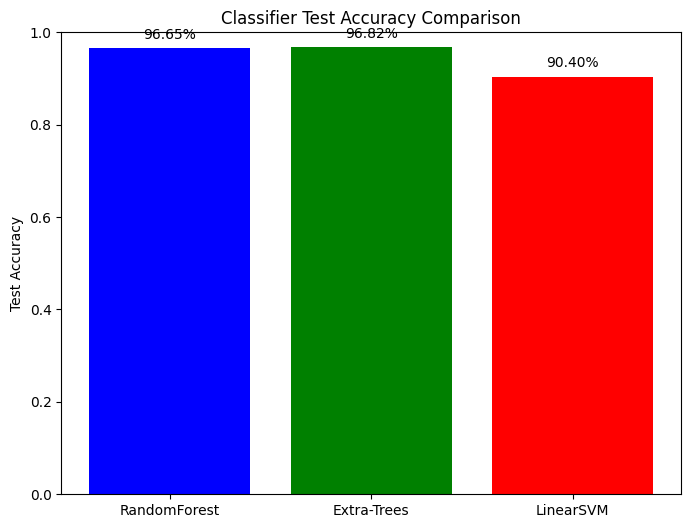

In [ ]:
# plot the RandomForestClassifier, Extra-Trees classifier, and SVM classifier accuracy comparison bar chart

models = ['RandomForest', 'Extra-Trees', 'LinearSVM']
test_accuracies = [rf_test_acc, et_test_acc, svm_test_acc]
plt.figure(figsize=(8, 6))
plt.bar(models, test_accuracies, color=['blue', 'green', 'red'])
plt.ylim(0, 1)
plt.ylabel('Test Accuracy')
plt.title('Classifier Test Accuracy Comparison')
for i, acc in enumerate(test_accuracies):
    plt.text(i, acc + 0.02, f"{acc * 100:.2f}%", ha='center', fontsize=10)
plt.show()

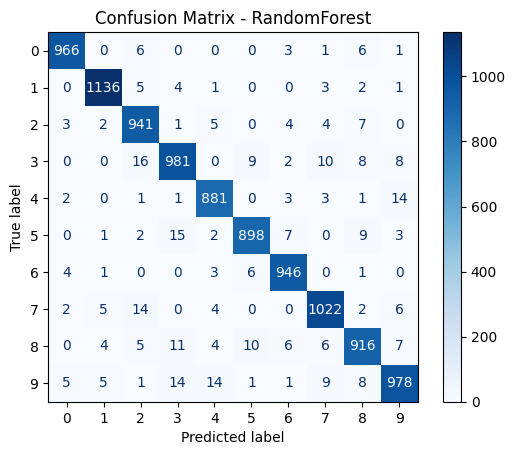

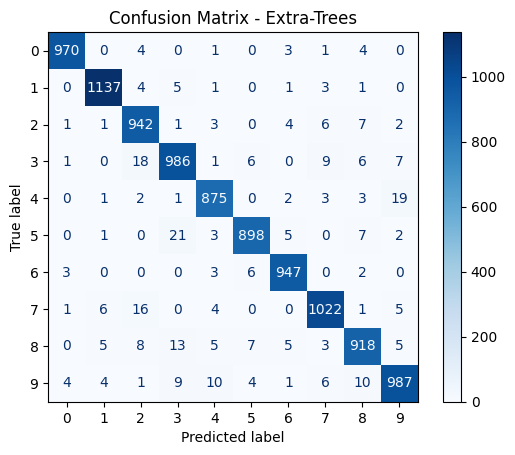

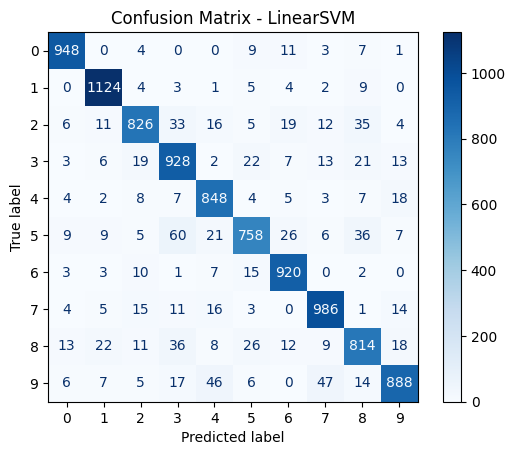

In [ ]:
# Show each classifier's confusion matrix on the test set

for model, name in zip([rf_final, et_final, lin_svm_final],
                       ['RandomForest', 'Extra-Trees', 'LinearSVM']):
    y_pred = model.predict(X_test)
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues)
    disp.ax_.set_title(f'Confusion Matrix - {name}')
    plt.show()